Enhancing Customer Experience: Mac Cosmetics Recommendation Engine

In [77]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [78]:
data = pd.read_csv('/Users/kanmaniratnasabapathy/Desktop/Fall Term/Data Science Term 2/Mac.csv')

Generating Product Recommendations for a Specific User

In [80]:
# Calculating Adjusted ratings based on user activity

activity_weight = {
    'Purchased': 1.0,  # Highest engagement
    'Wish Listed': 0.75,  # Moderate engagement
    'Browsed': 0.5  # Lowest engagement
}

In [81]:
data['Adjusted Rating'] = data['Rating'] * data['User Activity Type'].map(activity_weight)

We use  .fillna(0)  to fill in missing values in the pivot table. In the context of a ratings matrix, this is particularly useful as not every user will have rated every product. By filling missing ratings with 0, we are essentially treating non-rated products as having a rating of 0, which is a common practice in recommendation systems.

In [82]:
# Creating a pivot table 
pivot_table = data.pivot_table(index='User ID', columns='Product Name', values='Adjusted Rating').fillna(0)

 The function `predict_user_based` is defined to take two parameters: `ratings` and `similarity`. `ratings` is a matrix where each row represents a user and each column represents a product and the entries are the ratings given by users to these items. `similarity` is a matrix where each element (i, j) represents the similarity between user i and user j.

 A zero matrix `pred` of the same shape as the `ratings` matrix is initialized. This matrix will be used to store the predicted ratings.

 Two nested loops iterate over each user (i) and each item (j). The goal is to predict the rating user i would give to item j.

For each user i, the function finds the top 5 similar users. This is done by sorting the similarity scores for user i in descending order and selecting the indices of the top 5 scores. It's important to note that the user itself is excluded (`[1:6]`), ensuring that the user is not considered as a similar user to themselves.

 For each of the top similar users (indexed by k), the code aggregates the ratings these similar users have given to item j. The predicted rating is a weighted sum where weights are the similarity scores between the active user i and the similar users k. In other words, the higher the similarity, the more influence a user's rating has on the prediction.

 After summing the weighted ratings, the predicted rating for user i and item j is normalized by dividing it by the sum of the absolute similarity scores of the top similar users. This step ensures that the predicted rating is scaled appropriately, reflecting the relative influence of each similar user's rating.

Finally, after iterating over all users and items, the function returns the `pred` matrix, which contains the predicted ratings for all user-item pairs.

This function predicts a user's rating for an item based on the ratings that similar users have given to the same item. The underlying assumption is that users who are similar (based on their rating patterns) will have similar preferences and hence will rate items similarly. 

In [83]:
# User-Based Collaborative Filtering Function to predict user-based ratings

def predict_user_based(ratings, similarity):
    pred = np.zeros(ratings.shape)
    for i in range(ratings.shape[0]):
        for j in range(ratings.shape[1]):
            top_similar_users = similarity[i].argsort()[::-1][1:6]  # Top 5 similar users
            for k in top_similar_users:
                pred[i, j] += similarity[i, k] * ratings[k, j]
            pred[i, j] /= np.sum(np.abs(similarity[i, top_similar_users]))
    return pred

Importance of Similarity Matrix (Cosine Similarity):

User Similarity: Cosine similarity is calculated between users based on their ratings of different products. This step is crucial in understanding how similar each customer is to others in terms of their preferences and behaviors.

Personalized Recommendations: By understanding user similarity, the store can make more accurate recommendations. For instance, products liked by users with high similarity scores to a particular customer can be recommended to that customer.


In [84]:
# Calculating user similarity
user_similarity = cosine_similarity(pivot_table)

# Predicting  ratings
user_predicted_ratings = predict_user_based(pivot_table.values, user_similarity)

# Generating Recommendation and Converting  the predictions to a DataFrame
user_predicted_ratings_df = pd.DataFrame(user_predicted_ratings, 
                                         index=pivot_table.index, 
                                         columns=pivot_table.columns)

In [85]:
# Selecting recommendations for user ID 9970
user_id = 9970
user_recommendations = user_predicted_ratings_df.loc[user_id].sort_values(ascending=False)

# Displaying the top 5 recommendations for the user ID 9970
user_recommendations.head(5)

Product Name
Ruby Red Lip Liner        2.7
Bold Blue Eyeliner        0.0
ProBlend Blending         0.0
Mystic Mauve Eyeshadow    0.0
Mystic Mauve Mascara      0.0
Name: 9970, dtype: float64

In [86]:
# Selecting recommendations for user ID 7410
user_id = 7410
user_recommendations = user_predicted_ratings_df.loc[user_id].sort_values(ascending=False)

# Displaying the top 5 recommendations for the user ID 7410
user_recommendations.head(5)

Product Name
ProBlend Powder           2.631546
Coral Charm Lipstick      0.448864
FineContour Contouring    0.199382
Bold Blue Eyeliner        0.000000
ProBlend Contouring       0.000000
Name: 7410, dtype: float64

We can Calculate how often recommendeded items are actually interacted with by the users using the  post-recommendation interaction data - HIT RATE 

In [87]:
# Pseudocode - To calculate the Hit rate 
"""
hits = 0
total_recommendations = 0

for user_id in user_predicted_ratings_df.index:
    # Get top N recommendations for the user
    top_recommendations = user_predicted_ratings_df.loc[user_id].sort_values(ascending=False).head(N)
    
    # Check if these recommendations are in the user's actual interactions
    for item in top_recommendations.index:
        if item in actual_user_interactions[user_id]:
            hits += 1
    total_recommendations += N

hit_rate = hits / total_recommendations
print(f"Hit Rate: {hit_rate}")
"""

'\nhits = 0\ntotal_recommendations = 0\n\nfor user_id in user_predicted_ratings_df.index:\n    # Get top N recommendations for the user\n    top_recommendations = user_predicted_ratings_df.loc[user_id].sort_values(ascending=False).head(N)\n    \n    # Check if these recommendations are in the user\'s actual interactions\n    for item in top_recommendations.index:\n        if item in actual_user_interactions[user_id]:\n            hits += 1\n    total_recommendations += N\n\nhit_rate = hits / total_recommendations\nprint(f"Hit Rate: {hit_rate}")\n'

Clustering 

The primary goal here is to segment the user/ customer base into distinct groups (clusters) with similar characteristics or behaviors. This segmentation allows for more personalized marketing strategies, potentially leading to higher customer engagement and increased sales.

Using Clustering (K-Means): 

Segmentation: K-Means clustering is applied to the preprocessed customer data, which includes both categorical (like gender, age group, skin type) and numerical features (like retail price, adjusted rating, user similarity).

Targeted Marketing: Once customers are grouped into clusters, marketing strategies can be tailored to the specific preferences and behaviors of each cluster. For example, one cluster might respond better to premium product ads, while another might be more receptive to discounts on best-sellers.

Marketing Strategy Refinement: The similarity score is used to further refine marketing strategies. High similarity users might be targeted with products that their peers like, while low similarity users might be presented with a broader range of products to gauge their preferences.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to '

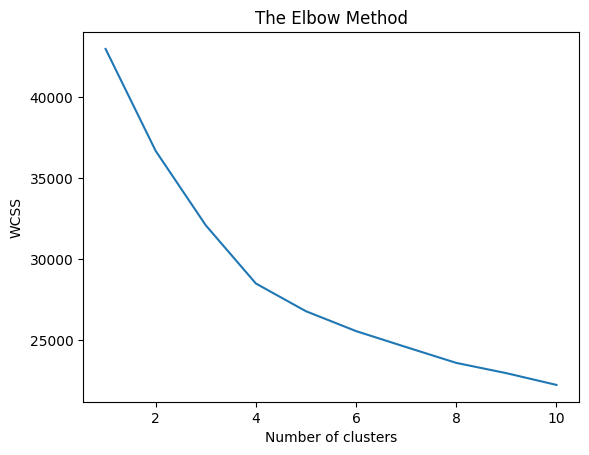

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [88]:
# For each user,we calculate the average similarity with other users
user_avg_similarity = user_similarity.mean(axis=1)

# Creating a DataFrame from user_avg_similarity with User ID as the index
similarity_df = pd.DataFrame(user_avg_similarity, index=pivot_table.index, columns=['User Similarity'])

# Merging the similarity DataFrame with the original data
data = pd.merge(data, similarity_df, left_on='User ID', right_index=True)

# Selecting the relevant features for clustering such 'Gender', 'Age Group', 'Skin Type', 'Retail Price', 'Adjusted rating' , 'User Similarity'
categorical_features = ['Gender', 'Age Group', 'Skin Type']
numerical_features = ['Retail Price', 'Adjusted Rating', 'User Similarity']
features = data[categorical_features + numerical_features]

# Creating a pipeline for numerical features: imputing missing values and  scaling
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Imputing missing values with mean
    ('scaler', StandardScaler())
])

# Creating a pipeline for categorical features: impute missing values, then one-hot encode
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputing missing values with most frequent
    ('encoder', OneHotEncoder())
])

# Creating a ColumnTransformer to apply different preprocessing to categorical and numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ]
)

# Applying the preprocessing to your features
scaled_features = preprocessor.fit_transform(data)

# Determining the optimal number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

# Plotting the WCSS to find the elbow
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Applying  K-Means Clustering
optimal_clusters = 4  # Replace with the actual elbow point
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', random_state=42)
clusters = kmeans.fit_predict(scaled_features)

# Adding cluster information to the original data
data['Cluster'] = clusters


Cluster Analysis: The centroids of the clusters give insights into the defining characteristics of each cluster. This information can guide the development of marketing campaigns.

In [94]:
# Applying K-Means Clustering with the chosen number of clusters
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', random_state=42)
clusters = kmeans.fit_predict(scaled_features)

# Adding cluster information to the original data
data['Cluster'] = clusters

# Analyzing  clusters for targeted marketing , like looking at the centroid values and distribution of features within each cluster
cluster_centers = kmeans.cluster_centers_
print("Cluster Centers:")
print(cluster_centers)

# Converting  cluster centers to a DataFrame for easier interpretation

columns = [f'Feature_{i}' for i in range(cluster_centers.shape[1])]
cluster_centers_df = pd.DataFrame(cluster_centers, columns=columns)
print(cluster_centers_df)



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster Centers:
[[-0.86561005 -0.36101751 -0.05590854  0.50610969  0.49389031  0.20289855
   0.17959648  0.20289855  0.20147769  0.21312873  0.20204604  0.20488775
   0.19863598  0.20176186  0.19266837]
 [ 0.87418358 -0.38748444  0.02304007  0.48893419  0.51106581  0.19860221
   0.20792079  0.1977286   0.19947583  0.19627257  0.20704718  0.18899243
   0.21636575  0.19539895  0.19219569]
 [ 0.03002406  1.76941646  0.08001534  0.5122449   0.4877551   0.18911565
   0.20884354  0.21088435  0.19863946  0.19251701  0.20340136  0.20884354
   0.21972789  0.17959184  0.18843537]]
   Feature_0  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5   
0  -0.865610  -0.361018  -0.055909   0.506110   0.493890   0.202899  \
1   0.874184  -0.387484   0.023040   0.488934   0.511066   0.198602   
2   0.030024   1.769416   0.080015   0.512245   0.487755   0.189116   

   Feature_6  Feature_7  Feature_8  Feature_9  Feature_10  Feature_11   
0   0.179596   0.202899   0.201478   0.213129    0.202046    0.

User Segmentation Based on Thresholds: Users are segmented based on their average similarity scores and adjusted ratings. Different marketing approaches are suggested for each segment, such as targeting users with high similarity and high adjusted ratings with premium products.

Defining a marketing strategy based on user similarity and adjusted rating

In [95]:
# Defining  thresholds
similarity_threshold = 0.5  # This is an example threshold for high similarity
rating_threshold = 0.75  # This is an example threshold for high adjusted rating

# Segmenting users by similarity
high_similarity_users = data[data['User Similarity'] > similarity_threshold]
low_similarity_users = data[data['User Similarity'] <= similarity_threshold]

# Determining marketing actions based on adjusted rating
for user_id, user_data in high_similarity_users.groupby('User ID'):
    if user_data['Adjusted Rating'].mean() > rating_threshold:
        # Users with high similarity and high adjusted rating
        print(f"User {user_id} could be targeted with premium product ads and loyalty programs.")
    else:
        # Users with high similarity but lower adjusted rating
        print(f"User {user_id} could be targeted with ads for products that their similar peers have rated highly.")

for user_id, user_data in low_similarity_users.groupby('User ID'):
    if user_data['Adjusted Rating'].mean() > rating_threshold:
        # Users with low similarity but high adjusted rating
        print(f"User {user_id} could be targeted with best-seller product ads and discounts on high-rated products.")
    else:
        # Users with low similarity and lower adjusted rating
        print(f"User {user_id} could be targeted with more diverse product ads to explore their preferences.")


User 1000 could be targeted with best-seller product ads and discounts on high-rated products.
User 1002 could be targeted with best-seller product ads and discounts on high-rated products.
User 1003 could be targeted with best-seller product ads and discounts on high-rated products.
User 1005 could be targeted with best-seller product ads and discounts on high-rated products.
User 1007 could be targeted with best-seller product ads and discounts on high-rated products.
User 1008 could be targeted with best-seller product ads and discounts on high-rated products.
User 1009 could be targeted with best-seller product ads and discounts on high-rated products.
User 1010 could be targeted with best-seller product ads and discounts on high-rated products.
User 1012 could be targeted with best-seller product ads and discounts on high-rated products.
User 1013 could be targeted with best-seller product ads and discounts on high-rated products.
User 1014 could be targeted with best-seller produ

Pesudo Code - Posting the Targetted ads to the front end from clustering 

In [91]:
""" 

import requests  # Assuming requests library for HTTP requests

def send_marketing_materials_to_frontend(user_id, materials):
    # Replace with the actual URL of your frontend system's API
    api_url = "http://MAC-frontend-system/api/marketing-materials"
    
    # Prepare the payload for the API request
    payload = {
        "user_id": user_id,
        "marketing_materials": materials
    }

    # Send a POST request to the frontend API
    response = requests.post(api_url, json=payload)
    
    # Check if the request was successful
    if response.status_code == 200:
        print(f"Marketing materials sent to user {user_id} successfully.")
    else:
        print(f"Failed to send marketing materials to user {user_id}. Status Code: {response.status_code}")

# Example of implementing the marketing actions
for user_id, user_data in data.groupby('User ID'):
    if user_data['User Similarity'].mean() > similarity_threshold:
        if user_data['Adjusted Rating'].mean() > rating_threshold:
            # Define premium product materials
            materials = "Premium Product Ads"
        else:
            # Define ads for products rated highly by similar users
            materials = "Peer Influenced Ads"
    else:
        if user_data['Adjusted Rating'].mean() > rating_threshold:
            # Define best-seller product ads
            materials = "Best-Seller Product Ads"
        else:
            # Define diverse product ads
            materials = "Diverse Product Ads"
    
    # Send the materials to the frontend
    send_marketing_materials_to_frontend(user_id, materials)
    """

' \n\nimport requests  # Assuming requests library for HTTP requests\n\ndef send_marketing_materials_to_frontend(user_id, materials):\n    # Replace with the actual URL of your frontend system\'s API\n    api_url = "http://MAC-frontend-system/api/marketing-materials"\n    \n    # Prepare the payload for the API request\n    payload = {\n        "user_id": user_id,\n        "marketing_materials": materials\n    }\n\n    # Send a POST request to the frontend API\n    response = requests.post(api_url, json=payload)\n    \n    # Check if the request was successful\n    if response.status_code == 200:\n        print(f"Marketing materials sent to user {user_id} successfully.")\n    else:\n        print(f"Failed to send marketing materials to user {user_id}. Status Code: {response.status_code}")\n\n# Example of implementing the marketing actions\nfor user_id, user_data in data.groupby(\'User ID\'):\n    if user_data[\'User Similarity\'].mean() > similarity_threshold:\n        if user_data[\'A

Model Validation - KMeans Clustering

In [96]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Calculating Silhouette Score
silhouette_avg = silhouette_score(scaled_features, clusters)
print(f"Silhouette Score: {silhouette_avg}")

# Calculating Calinski-Harabasz Index
calinski_harabasz = calinski_harabasz_score(scaled_features, clusters)
print(f"Calinski-Harabasz Index: {calinski_harabasz}")

# Calculating Davies-Bouldin Index
davies_bouldin = davies_bouldin_score(scaled_features, clusters)
print(f"Davies-Bouldin Index: {davies_bouldin}")

Silhouette Score: 0.15048643042007964
Calinski-Harabasz Index: 1425.8142333374974
Davies-Bouldin Index: 2.0192507581513466


Heirarchical Clustering 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


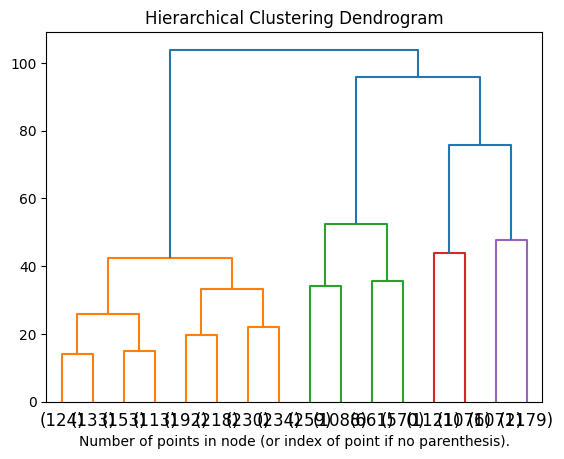

In [97]:

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

data['Adjusted Rating'] = data['Rating'] * data['User Activity Type'].map(activity_weight)

# Creating a pivot table for user-item interactions
pivot_table = data.pivot_table(index='User ID', columns='Product Name', values='Adjusted Rating').fillna(0)

# Calculating user similarity
user_similarity = cosine_similarity(pivot_table)

# Applying the preprocessing to your features
scaled_features = preprocessor.fit_transform(data)

# Applying Hierarchical Clustering , Using the Ward method to minimize the variance of clusters being merged.
hierarchical_clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=0, affinity='euclidean', linkage='ward')
clusters = hierarchical_clustering.fit_predict(scaled_features)

# Adding cluster information to the original data
data['Cluster'] = clusters

# Plotting the Dendrogram
def plot_dendrogram(model, **kwargs):
    # Creating  linkage matrix and then plot the dendrogram
    # creating   counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    
    dendrogram(linkage_matrix, **kwargs)

plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(hierarchical_clustering, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()



In [98]:
hierarchical_clustering = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
clusters = hierarchical_clustering.fit_predict(scaled_features)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [109]:
pip install gower

Note: you may need to restart the kernel to use updated packages.


Using gower to handle mixed data type 

In [111]:
from sklearn.impute import SimpleImputer
import gower
from sklearn.cluster import AgglomerativeClustering

# Imputing missing values for numerical data, replacing NaNs with the mean value of the column. For categorical data, replacing NaNs with the most frequent value of the column (mode)
imputer = SimpleImputer(strategy='mean')  # or use 'median'
data_numeric = imputer.fit_transform(data.select_dtypes(include=[np.number]))

imputer = SimpleImputer(strategy='most_frequent')
data_categorical = imputer.fit_transform(data.select_dtypes(exclude=[np.number]))

# Recombining the numeric and categorical data
data_imputed = np.hstack((data_numeric, data_categorical))

# Computing the Gower distance matrix
distance_matrix = gower.gower_matrix(data_imputed)

# Applying hierarchical clustering using the precomputed distance matrix
hierarchical_clustering = AgglomerativeClustering(n_clusters=4, affinity='precomputed', linkage='complete')
clusters = hierarchical_clustering.fit_predict(distance_matrix)

# Adding the cluster labels to your original DataFrame
data['Cluster'] = clusters


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [112]:
data['Cluster'] = clusters

In [113]:
clusters

array([2, 3, 2, ..., 0, 0, 0])

In [120]:
numeric_data = data.select_dtypes(include=[np.number])
cluster_analysis_numeric = numeric_data.groupby(data['Cluster']).mean()
print(cluster_analysis_numeric)


                  ID      User ID  Retail Price    Rating  Adjusted Rating   
Cluster                                                                      
0        5001.266981  5567.816274     29.630995  2.746934         1.732609  \
1        5079.199703  5469.812918     29.553846  2.824053         1.730297   
2        5017.338710  5589.194282     30.208152  4.398827         4.391862   
3        4869.689538  5601.699049     30.002561  2.741168         1.775954   

         User Similarity  Cluster  
Cluster                            
0               0.030396      0.0  
1               0.029688      1.0  
2               0.030307      2.0  
3               0.030363      3.0  


In [104]:
# Trying different number of clusters
for n_clusters in range(2, 6):
    model = AgglomerativeClustering(n_clusters=n_clusters)
    clusters = model.fit_predict(scaled_features)
    score = silhouette_score(scaled_features, clusters)
    print(f"Silhouette Score for {n_clusters} clusters: {score}")


Silhouette Score for 2 clusters: 0.18494066680006677
Silhouette Score for 3 clusters: 0.13806402180239583
Silhouette Score for 4 clusters: 0.10849198425619734
Silhouette Score for 5 clusters: 0.09675452066853654


In [122]:
# Calculating Silhouette Score
silhouette_avg = silhouette_score(scaled_features, clusters)
print(f"Silhouette Score: {silhouette_avg}")

# Calculating Calinski-Harabasz Index
calinski_harabasz = calinski_harabasz_score(scaled_features, clusters)
print(f"Calinski-Harabasz Index: {calinski_harabasz}")

# Calculating Davies-Bouldin Index
davies_bouldin = davies_bouldin_score(scaled_features, clusters)
print(f"Davies-Bouldin Index: {davies_bouldin}")

Silhouette Score: 0.023547676319481216
Calinski-Harabasz Index: 371.76393840747704
Davies-Bouldin Index: 45.8966631240811


When comparing KMeans and Hierarchical Clustering for realtime deployment in our business case - MAC  marketing strategy, 

1. Computational Efficiency:
    KMeans: Generally faster and more computationally efficient, especially for large datasets. This is crucial for realtime applications where quick updates are needed based on new data (e.g., daily customer transactions).
    Hierarchical Clustering: More computationally intensive, especially at scale. It's less suitable for very large datasets or for scenarios where the clustering needs to be updated frequently.

2. Scalability:
    KMeans: Scales well with the number of data points, making it a good choice for retail stores with large customer bases or extensive product ranges.
    Hierarchical Clustering: Does not scale as well with large datasets, which can be a limitation in a dynamic retail environment.

3. Flexibility and Adaptability:
    KMeans: Offers flexibility in terms of the number of clusters (which can be adjusted based on business needs). However, it assumes clusters to be spherical and may not capture more complex structures.
    Hierarchical Clustering: Provides a detailed dendrogram, which can offer insights into the data structure and allow for flexibility in choosing the number of clusters. However, it's less adaptable to changes in data over time.

4. Interpretability:
    KMeans: The centroids of clusters can be easily interpreted and used for profiling customer segments or product categories.
    Hierarchical Clustering: Provides a dendrogram that can be more difficult to interpret but offers a more nuanced view of data relationships.

5. RealTime Data Updates:
    KMeans: More suitable for environments where clusters need to be updated regularly with new customer data or changing inventory.
    Hierarchical Clustering: Less suited for frequent updates due to its computational complexity.

6. Application in Marketing Strategy:
    KMeans: Its speed and scalability make it wellsuited for segmenting customers for targeted marketing campaigns, product recommendations, and inventory management.
    Hierarchical Clustering: Might be more useful in a strategic, less frequent analysis for understanding the broader market structure or customer base.

For realtime deployment in a retail store marketing strategy for MAC , KMeans is generally more advantageous due to its efficiency, scalability, and ease of updating with new data. It aligns well with the dynamic and fastpaced nature of retail marketing, where strategies need to be adjusted frequently based on customer behavior and market trends.

A combined approach, using KMeans for operational daytoday segmentation and Hierarchical Clustering for deeper, strategic insights, can also be considered.